# 04 - Classification Binaire avec TensorFlow

**Objectif du notebook :**
- Implémentation d'un réseau de neurones (DNN) pour la classification binaire
- Prédiction du statut de complétion du cours (Completed / Not Completed)

**Architecture :**
- Réseau dense (MLP/DNN) avec couches cachées
- Fonction d'activation finale : Sigmoid (sortie binaire)
- Loss function : Binary Crossentropy
- Gestion du déséquilibre des classes (class_weight)
- Métriques : Accuracy, Precision, Recall, F1-Score, AUC-ROC

---

## 1. Imports et Configuration

In [1]:
"""Importation des bibliothèques nécessaires."""

# Data manipulation
import numpy as np
import pandas as pd
import pickle

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers import Adam

# Métriques et évaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.utils.class_weight import compute_class_weight

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Seed pour la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Configuration GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"✓ GPU disponible : {physical_devices[0].name}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("⚠️  Aucun GPU détecté, utilisation du CPU")

print(f"✓ TensorFlow version : {tf.__version__}")
print(f"✓ Keras version : {keras.__version__}")
print(f"✓ Random state : {RANDOM_STATE}")

⚠️  Aucun GPU détecté, utilisation du CPU
✓ TensorFlow version : 2.20.0
✓ Keras version : 3.11.3
✓ Random state : 42


## 2. Chargement des Données Prétraitées

In [2]:
"""Chargement des données prétraitées."""

print("="*70)
print(" CHARGEMENT DES DONNÉES")
print("="*70)

data_dir = 'tensorflow_preprocessed_data'

# Chargement des données
X_train = np.load(f'{data_dir}/X_train.npy')
y_cls_train = np.load(f'{data_dir}/y_cls_train.npy')

X_val = np.load(f'{data_dir}/X_val.npy')
y_cls_val = np.load(f'{data_dir}/y_cls_val.npy')

X_test = np.load(f'{data_dir}/X_test.npy')
y_cls_test = np.load(f'{data_dir}/y_cls_test.npy')

# Chargement de la configuration
with open(f'{data_dir}/config.pkl', 'rb') as f:
    config = pickle.load(f)

# Chargement des noms de features
with open(f'{data_dir}/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print("\nDonnées chargées :")
print(f"  X_train      : {X_train.shape}")
print(f"  y_cls_train  : {y_cls_train.shape}")
print(f"  X_val        : {X_val.shape}")
print(f"  y_cls_val    : {y_cls_val.shape}")
print(f"  X_test       : {X_test.shape}")
print(f"  y_cls_test   : {y_cls_test.shape}")

print(f"\n✓ {config['n_features']} features chargées")
print(f"\nCible de classification : {config['classification_target']}")

 CHARGEMENT DES DONNÉES

Données chargées :
  X_train      : (70000, 71)
  y_cls_train  : (70000,)
  X_val        : (15000, 71)
  y_cls_val    : (15000,)
  X_test       : (15000, 71)
  y_cls_test   : (15000,)

✓ 71 features chargées

Cible de classification : Completed


## 3. Analyse de la Distribution des Classes

 ANALYSE DE LA DISTRIBUTION DES CLASSES

Train :
  Not Completed   : 35,679 (50.97%)
  Completed       : 34,321 (49.03%)
  Ratio déséquilibre : 1.04:1

Validation :
  Not Completed   :  7,646 (50.97%)
  Completed       :  7,354 (49.03%)
  Ratio déséquilibre : 1.04:1

Test :
  Not Completed   :  7,645 (50.97%)
  Completed       :  7,355 (49.03%)
  Ratio déséquilibre : 1.04:1


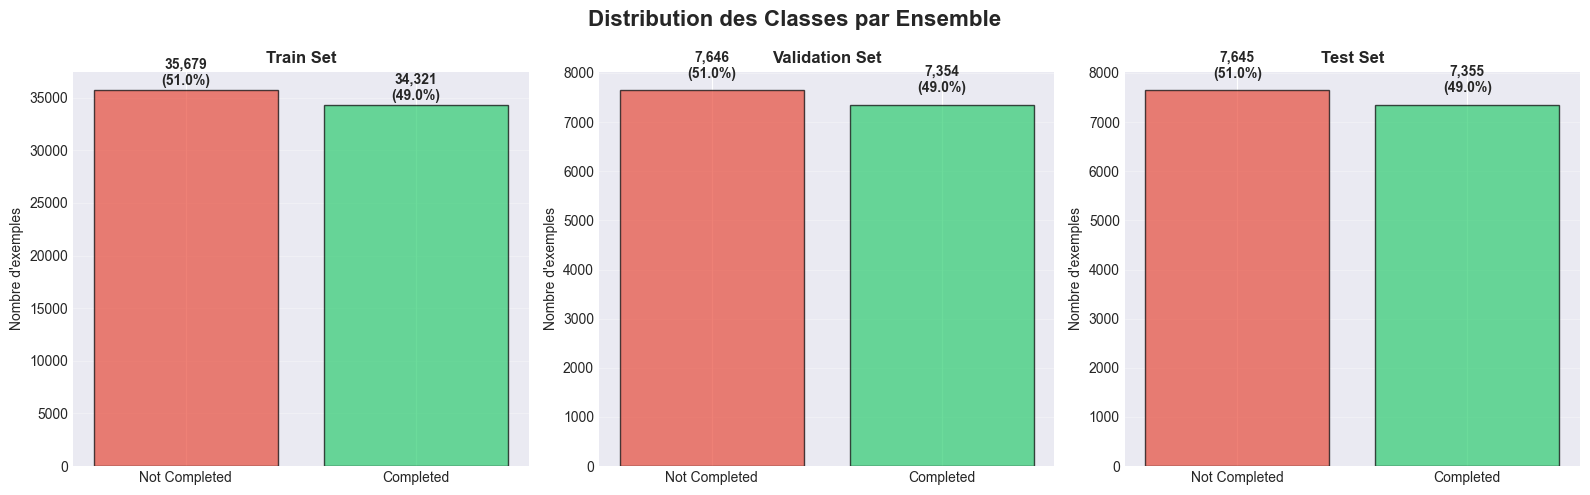

In [3]:
"""Analyse de la distribution des classes et calcul du déséquilibre."""

print("="*70)
print(" ANALYSE DE LA DISTRIBUTION DES CLASSES")
print("="*70)

# Distribution dans chaque ensemble
for dataset_name, y_data in [('Train', y_cls_train), ('Validation', y_cls_val), ('Test', y_cls_test)]:
    unique, counts = np.unique(y_data, return_counts=True)
    print(f"\n{dataset_name} :")
    for cls, count in zip(unique, counts):
        pct = (count / len(y_data)) * 100
        cls_name = "Completed" if cls == 1 else "Not Completed"
        print(f"  {cls_name:15s} : {count:6,} ({pct:5.2f}%)")
    
    # Ratio de déséquilibre
    imbalance_ratio = counts.max() / counts.min()
    print(f"  Ratio déséquilibre : {imbalance_ratio:.2f}:1")

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Distribution des Classes par Ensemble', fontsize=16, fontweight='bold')

datasets = [
    ('Train', y_cls_train),
    ('Validation', y_cls_val),
    ('Test', y_cls_test)
]

for ax, (name, y_data) in zip(axes, datasets):
    unique, counts = np.unique(y_data, return_counts=True)
    labels = ['Not Completed', 'Completed']
    colors = ['#e74c3c', '#2ecc71']
    
    ax.bar(labels, counts, color=colors, edgecolor='black', alpha=0.7)
    ax.set_title(f'{name} Set', fontsize=12, fontweight='bold')
    ax.set_ylabel('Nombre d\'exemples')
    ax.grid(axis='y', alpha=0.3)
    
    # Annotations
    for i, (label, count) in enumerate(zip(labels, counts)):
        pct = (count / len(y_data)) * 100
        ax.text(i, count + 200, f'{count:,}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Calcul des Poids de Classe

In [4]:
"""Calcul des poids de classe pour gérer le déséquilibre."""

print("="*70)
print(" CALCUL DES POIDS DE CLASSE")
print("="*70)

# Calcul automatique des poids
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_cls_train),
    y=y_cls_train
)

# Conversion en dictionnaire
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("\nPoids calculés :")
for cls, weight in class_weights.items():
    cls_name = "Completed" if cls == 1 else "Not Completed"
    print(f"  Classe {cls} ({cls_name:15s}) : {weight:.4f}")

print("\n⚠️  Ces poids seront utilisés pendant l'entraînement pour")
print("   compenser le déséquilibre des classes.")

 CALCUL DES POIDS DE CLASSE

Poids calculés :
  Classe 0 (Not Completed  ) : 0.9810
  Classe 1 (Completed      ) : 1.0198

⚠️  Ces poids seront utilisés pendant l'entraînement pour
   compenser le déséquilibre des classes.


## 5. Construction du Modèle de Classification

In [5]:
"""Construction de l'architecture du réseau de neurones pour la classification."""

def build_classification_model(input_dim,
                              hidden_layers=[256, 128, 64],
                              dropout_rate=0.4,
                              l2_reg=0.001,
                              learning_rate=0.001):
    """
    Construction d'un modèle DNN pour la classification binaire.
    
    Architecture :
    - Couches d'entrée avec normalisation batch
    - Couches cachées denses avec régularisation L2
    - Dropout pour la régularisation
    - Couche de sortie avec activation Sigmoid
    
    Args:
        input_dim: Nombre de features d'entrée
        hidden_layers: Liste des tailles de couches cachées
        dropout_rate: Taux de dropout
        l2_reg: Coefficient de régularisation L2
        learning_rate: Taux d'apprentissage
    
    Returns:
        Modèle Keras compilé
    """
    
    # Input layer
    inputs = keras.Input(shape=(input_dim,), name='input_features')
    
    # Première couche avec normalisation batch
    x = layers.Dense(
        hidden_layers[0],
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        kernel_initializer='he_normal',
        name='dense_1'
    )(inputs)
    x = layers.BatchNormalization(name='batch_norm_1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)
    
    # Couches cachées supplémentaires
    for i, units in enumerate(hidden_layers[1:], start=2):
        x = layers.Dense(
            units,
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg),
            kernel_initializer='he_normal',
            name=f'dense_{i}'
        )(x)
        x = layers.BatchNormalization(name=f'batch_norm_{i}')(x)
        x = layers.Dropout(dropout_rate, name=f'dropout_{i}')(x)
    
    # Couche de sortie (Sigmoid pour classification binaire)
    outputs = layers.Dense(
        1,
        activation='sigmoid',
        name='classification_output'
    )(x)
    
    # Création du modèle
    model = keras.Model(inputs=inputs, outputs=outputs, name='Classification_DNN')
    
    # Métriques personnalisées
    metrics = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
    
    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=metrics
    )
    
    return model

print("✓ Fonction de construction du modèle définie")

✓ Fonction de construction du modèle définie


In [6]:
"""Instanciation et affichage du modèle."""

print("="*70)
print(" CONSTRUCTION DU MODÈLE")
print("="*70)

# Hyperparamètres
HYPERPARAMS = {
    'hidden_layers': [256, 128, 64, 32],  # 4 couches cachées
    'dropout_rate': 0.4,
    'l2_reg': 0.001,
    'learning_rate': 0.001
}

# Construction du modèle
model_classification = build_classification_model(
    input_dim=X_train.shape[1],
    **HYPERPARAMS
)

# Affichage de l'architecture
print("\nArchitecture du modèle :")
model_classification.summary()

# Visualisation de l'architecture
keras.utils.plot_model(
    model_classification,
    to_file='tensorflow_classification_model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)
print("\n✓ Diagramme du modèle sauvegardé : tensorflow_classification_model.png")

 CONSTRUCTION DU MODÈLE

Architecture du modèle :


Model: "Classification_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 71)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output (Dense)   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,617 (248.50 KB)

 Trainable params: 62,657 (244.75 KB)

 Non-trainable params: 960 (3.75 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.

✓ Diagramme du modèle sauvegardé : tensorflow_classification_model.png


## 6. Configuration des Callbacks

In [7]:
"""Configuration des callbacks pour l'entraînement."""

print("="*70)
print(" CONFIGURATION DES CALLBACKS")
print("="*70)

# Création du dossier pour les sauvegardes
model_dir = 'tensorflow_classification_models'
os.makedirs(model_dir, exist_ok=True)

# 1. EarlyStopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=20,
    restore_best_weights=True,
    verbose=1,
    mode='max'  # Maximiser AUC
)
print("✓ EarlyStopping configuré (monitor=val_auc, patience=20)")

# 2. ReduceLROnPlateau
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)
print("✓ ReduceLROnPlateau configuré (factor=0.5, patience=10)")

# 3. ModelCheckpoint
checkpoint = callbacks.ModelCheckpoint(
    filepath=f'{model_dir}/best_classification_model.keras',
    monitor='val_auc',
    save_best_only=True,
    verbose=1,
    mode='max'
)
print("✓ ModelCheckpoint configuré")

# 4. TensorBoard
log_dir = f'tensorflow_logs/classification_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard = callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True
)
print(f"✓ TensorBoard configuré (log_dir={log_dir})")

# 5. CSVLogger
csv_logger = callbacks.CSVLogger(
    f'{model_dir}/training_history.csv',
    append=False
)
print("✓ CSVLogger configuré")

# Liste de tous les callbacks
callback_list = [
    early_stopping,
    reduce_lr,
    checkpoint,
    tensorboard,
    csv_logger
]

print(f"\n✓ {len(callback_list)} callbacks configurés")

 CONFIGURATION DES CALLBACKS
✓ EarlyStopping configuré (monitor=val_auc, patience=20)
✓ ReduceLROnPlateau configuré (factor=0.5, patience=10)
✓ ModelCheckpoint configuré
✓ TensorBoard configuré (log_dir=tensorflow_logs/classification_20251215-231838)
✓ CSVLogger configuré

✓ 5 callbacks configurés


## 7. Entraînement du Modèle

In [8]:
"""Entraînement du modèle de classification avec gestion du déséquilibre."""

print("="*70)
print(" ENTRAÎNEMENT DU MODÈLE")
print("="*70)

# Hyperparamètres d'entraînement
EPOCHS = 200
BATCH_SIZE = 64

print(f"\nConfiguration :")
print(f"  Epochs       : {EPOCHS}")
print(f"  Batch size   : {BATCH_SIZE}")
print(f"  Train samples: {len(X_train):,}")
print(f"  Val samples  : {len(X_val):,}")
print(f"  Class weights: {class_weights}")
print(f"\nDébut de l'entraînement...\n")

# Entraînement avec class_weight
history = model_classification.fit(
    X_train, y_cls_train,
    validation_data=(X_val, y_cls_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,  # Gestion du déséquilibre
    callbacks=callback_list,
    verbose=1
)

print("\n" + "="*70)
print(" ENTRAÎNEMENT TERMINÉ")
print("="*70)
print(f"✓ Nombre d'epochs effectués : {len(history.history['loss'])}")

 ENTRAÎNEMENT DU MODÈLE

Configuration :
  Epochs       : 200
  Batch size   : 64
  Train samples: 70,000
  Val samples  : 15,000
  Class weights: {0: 0.9809691975671964, 1: 1.0197838058331634}

Début de l'entraînement...

Epoch 1/200
1083/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5349 - auc: 0.5465 - loss: 1.5926 - precision: 0.5227 - recall: 0.5078
Epoch 1: val_auc improved from None to 0.63551, saving model to tensorflow_classification_models/best_classification_model.keras
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5534 - auc: 0.5703 - loss: 1.4115 - precision: 0.5454 - recall: 0.5353 - val_accuracy: 0.5975 - val_auc: 0.6355 - val_loss: 1.1009 - val_precision: 0.6020 - val_recall: 0.5284 - learning_rate: 0.0010
Epoch 2/200
1088/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5925 - auc: 0.6287 - loss: 0.9969 - precision: 0.5790 - recall: 0.5961
Epoch 2: val_auc improved from 0.63551 to 0.64045, saving model to tensorflow_classification_models/best_classi

## 8. Visualisation de l'Entraînement

 ANALYSE DE L'ENTRAÎNEMENT


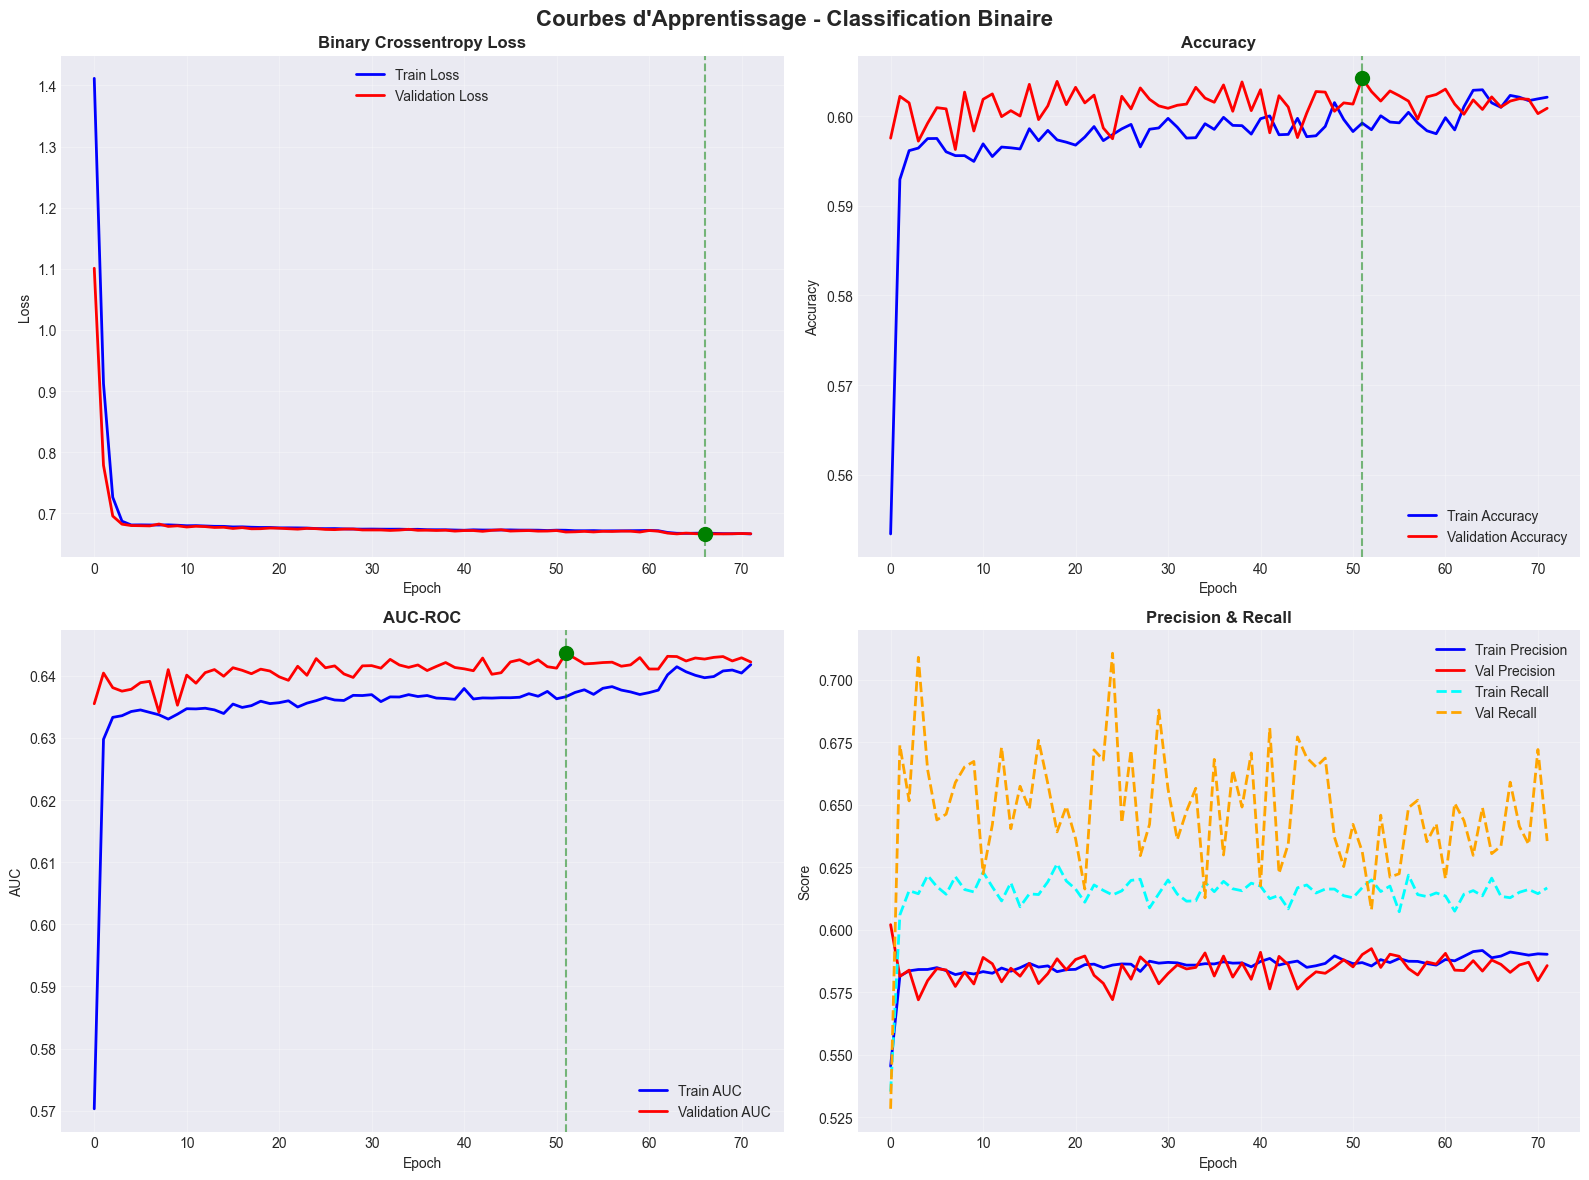


Meilleures performances :
  Validation Loss     : 0.6663 (epoch 66)
  Validation Accuracy : 0.6042 (epoch 51)
  Validation AUC      : 0.6436 (epoch 51)

✓ Courbes sauvegardées : tensorflow_classification_models/training_curves.png


In [9]:
"""Visualisation des courbes d'apprentissage."""

print("="*70)
print(" ANALYSE DE L'ENTRAÎNEMENT")
print("="*70)

# Création des graphiques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Courbes d\'Apprentissage - Classification Binaire', fontsize=16, fontweight='bold')

# 1. Loss
ax1 = axes[0, 0]
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
ax1.set_title('Binary Crossentropy Loss', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

min_val_loss = min(history.history['val_loss'])
min_loss_epoch = history.history['val_loss'].index(min_val_loss)
ax1.axvline(min_loss_epoch, color='green', linestyle='--', alpha=0.5)
ax1.plot(min_loss_epoch, min_val_loss, 'go', markersize=10)

# 2. Accuracy
ax2 = axes[0, 1]
ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='blue')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
ax2.set_title('Accuracy', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

max_val_acc = max(history.history['val_accuracy'])
max_acc_epoch = history.history['val_accuracy'].index(max_val_acc)
ax2.axvline(max_acc_epoch, color='green', linestyle='--', alpha=0.5)
ax2.plot(max_acc_epoch, max_val_acc, 'go', markersize=10)

# 3. AUC
ax3 = axes[1, 0]
ax3.plot(history.history['auc'], label='Train AUC', linewidth=2, color='blue')
ax3.plot(history.history['val_auc'], label='Validation AUC', linewidth=2, color='red')
ax3.set_title('AUC-ROC', fontsize=12, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.legend()
ax3.grid(True, alpha=0.3)

max_val_auc = max(history.history['val_auc'])
max_auc_epoch = history.history['val_auc'].index(max_val_auc)
ax3.axvline(max_auc_epoch, color='green', linestyle='--', alpha=0.5)
ax3.plot(max_auc_epoch, max_val_auc, 'go', markersize=10)

# 4. Precision & Recall
ax4 = axes[1, 1]
ax4.plot(history.history['precision'], label='Train Precision', linewidth=2, color='blue')
ax4.plot(history.history['val_precision'], label='Val Precision', linewidth=2, color='red')
ax4.plot(history.history['recall'], label='Train Recall', linewidth=2, color='cyan', linestyle='--')
ax4.plot(history.history['val_recall'], label='Val Recall', linewidth=2, color='orange', linestyle='--')
ax4.set_title('Precision & Recall', fontsize=12, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Score')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{model_dir}/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMeilleures performances :")
print(f"  Validation Loss     : {min_val_loss:.4f} (epoch {min_loss_epoch})")
print(f"  Validation Accuracy : {max_val_acc:.4f} (epoch {max_acc_epoch})")
print(f"  Validation AUC      : {max_val_auc:.4f} (epoch {max_auc_epoch})")
print(f"\n✓ Courbes sauvegardées : {model_dir}/training_curves.png")

## 9. Évaluation sur l'Ensemble de Test

In [10]:
"""Évaluation complète du modèle sur l'ensemble de test."""

print("="*70)
print(" ÉVALUATION SUR L'ENSEMBLE DE TEST")
print("="*70)

# Prédictions (probabilités)
y_pred_proba = model_classification.predict(X_test, verbose=0)

# Prédictions (classes) avec seuil de 0.5
y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()

# Calcul des métriques
accuracy = accuracy_score(y_cls_test, y_pred_classes)
precision = precision_score(y_cls_test, y_pred_classes, zero_division=0)
recall = recall_score(y_cls_test, y_pred_classes, zero_division=0)
f1 = f1_score(y_cls_test, y_pred_classes, zero_division=0)
auc_roc = roc_auc_score(y_cls_test, y_pred_proba)
avg_precision = average_precision_score(y_cls_test, y_pred_proba)

print("\nMétriques de Performance :")
print("="*70)
print(f"  Accuracy          : {accuracy:.4f}")
print(f"  Precision         : {precision:.4f}")
print(f"  Recall            : {recall:.4f}")
print(f"  F1-Score          : {f1:.4f}")
print(f"  AUC-ROC           : {auc_roc:.4f}")
print(f"  Average Precision : {avg_precision:.4f}")

# Rapport de classification détaillé
print("\n" + "="*70)
print(" RAPPORT DE CLASSIFICATION")
print("="*70)
target_names = ['Not Completed', 'Completed']
print(classification_report(y_cls_test, y_pred_classes, target_names=target_names))

 ÉVALUATION SUR L'ENSEMBLE DE TEST

Métriques de Performance :
  Accuracy          : 0.6019
  Precision         : 0.5889
  Recall            : 0.6226
  F1-Score          : 0.6053
  AUC-ROC           : 0.6427
  Average Precision : 0.6184

 RAPPORT DE CLASSIFICATION
               precision    recall  f1-score   support

Not Completed       0.62      0.58      0.60      7645
    Completed       0.59      0.62      0.61      7355

     accuracy                           0.60     15000
    macro avg       0.60      0.60      0.60     15000
 weighted avg       0.60      0.60      0.60     15000



## 10. Matrice de Confusion

 MATRICE DE CONFUSION


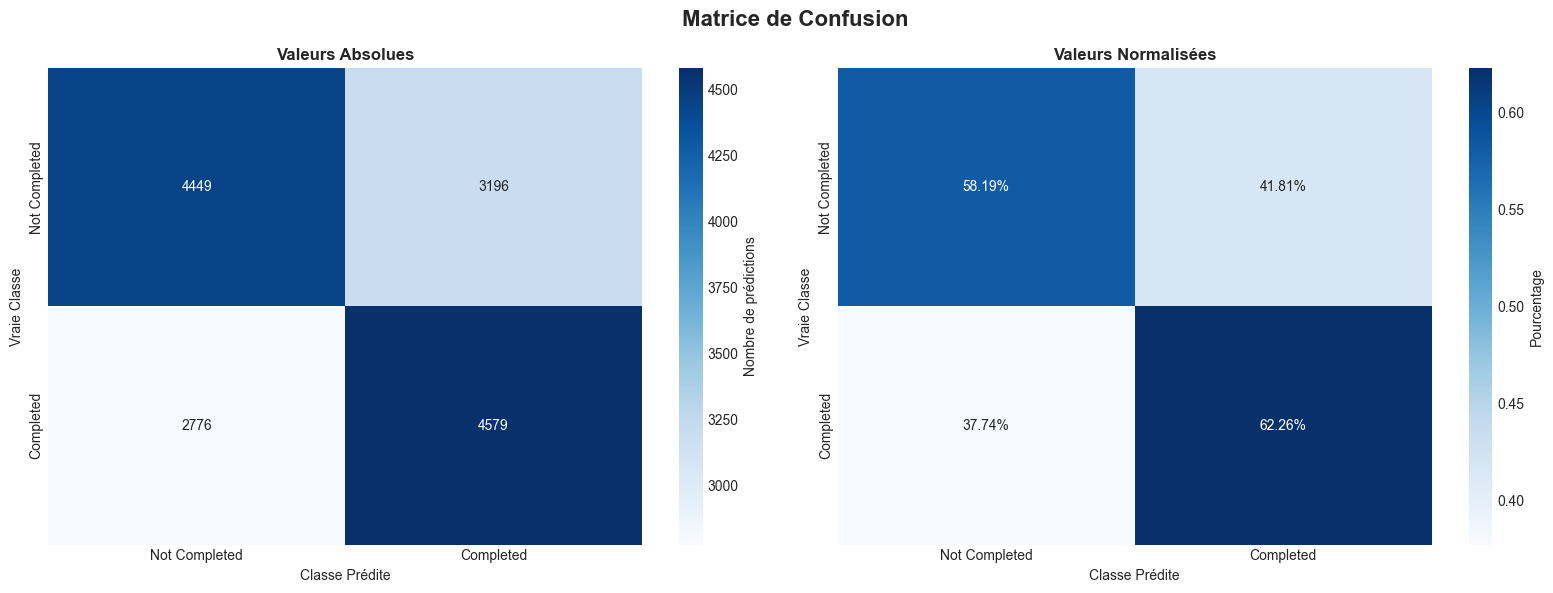


Détails de la matrice :
  True Negatives  (TN): 4,449
  False Positives (FP): 3,196
  False Negatives (FN): 2,776
  True Positives  (TP): 4,579

✓ Matrice sauvegardée : tensorflow_classification_models/confusion_matrix.png


In [11]:
"""Visualisation de la matrice de confusion."""

print("="*70)
print(" MATRICE DE CONFUSION")
print("="*70)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_cls_test, y_pred_classes)

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Matrice de Confusion', fontsize=16, fontweight='bold')

# 1. Valeurs absolues
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names,
            ax=ax1, cbar_kws={'label': 'Nombre de prédictions'})
ax1.set_title('Valeurs Absolues', fontsize=12, fontweight='bold')
ax1.set_ylabel('Vraie Classe')
ax1.set_xlabel('Classe Prédite')

# 2. Valeurs normalisées
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            ax=ax2, cbar_kws={'label': 'Pourcentage'})
ax2.set_title('Valeurs Normalisées', fontsize=12, fontweight='bold')
ax2.set_ylabel('Vraie Classe')
ax2.set_xlabel('Classe Prédite')

plt.tight_layout()
plt.savefig(f'{model_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyse de la matrice
tn, fp, fn, tp = cm.ravel()
print("\nDétails de la matrice :")
print(f"  True Negatives  (TN): {tn:,}")
print(f"  False Positives (FP): {fp:,}")
print(f"  False Negatives (FN): {fn:,}")
print(f"  True Positives  (TP): {tp:,}")

print(f"\n✓ Matrice sauvegardée : {model_dir}/confusion_matrix.png")

## 11. Courbes ROC et Precision-Recall

 COURBES ROC ET PRECISION-RECALL


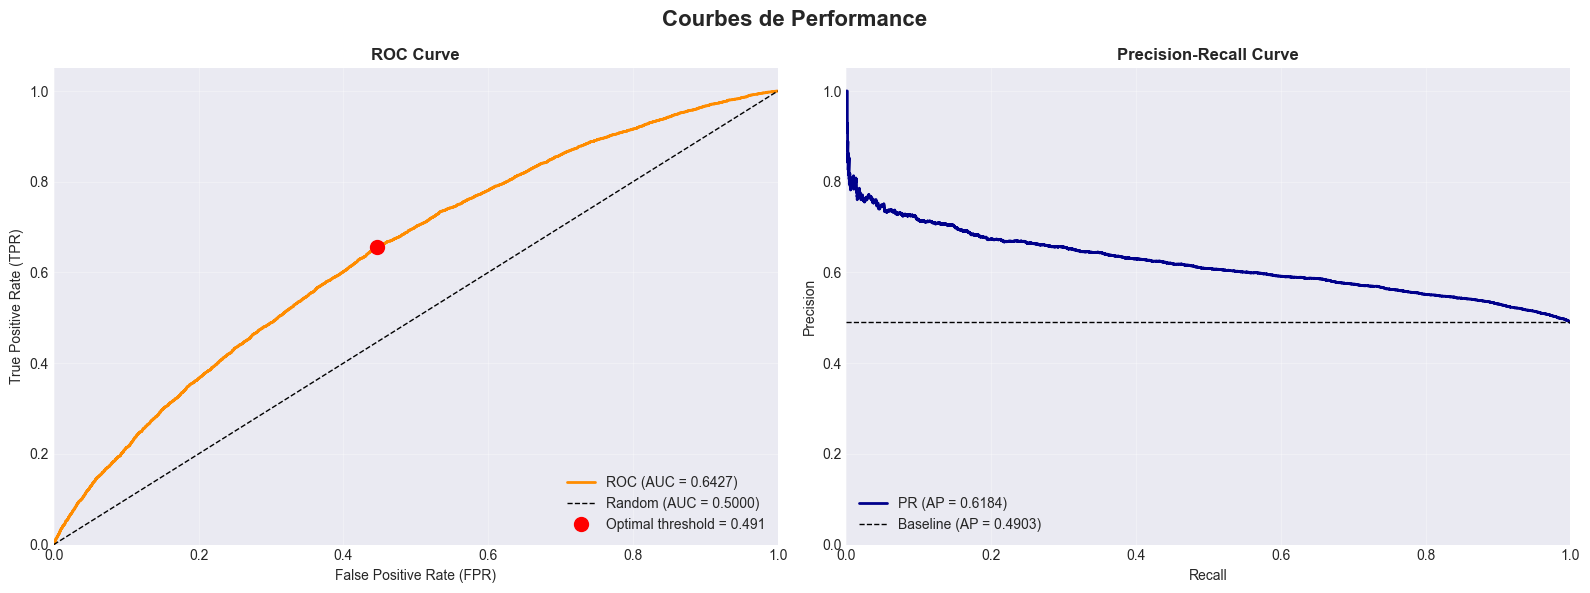


✓ Courbes sauvegardées : tensorflow_classification_models/roc_pr_curves.png

Seuil optimal (Youden's Index) : 0.4905
  TPR au seuil optimal : 0.6570
  FPR au seuil optimal : 0.4471


In [12]:
"""Visualisation des courbes ROC et Precision-Recall."""

print("="*70)
print(" COURBES ROC ET PRECISION-RECALL")
print("="*70)

# Calcul des courbes
fpr, tpr, roc_thresholds = roc_curve(y_cls_test, y_pred_proba)
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_cls_test, y_pred_proba)

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Courbes de Performance', fontsize=16, fontweight='bold')

# 1. Courbe ROC
ax1.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc_roc:.4f})', color='darkorange')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5000)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')
ax1.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Point optimal (Youden's Index)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = roc_thresholds[optimal_idx]
ax1.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
         label=f'Optimal threshold = {optimal_threshold:.3f}')
ax1.legend(loc='lower right')

# 2. Courbe Precision-Recall
ax2.plot(recall_curve, precision_curve, linewidth=2, 
         label=f'PR (AP = {avg_precision:.4f})', color='darkblue')
# Baseline (proportion de la classe positive)
baseline = y_cls_test.mean()
ax2.plot([0, 1], [baseline, baseline], 'k--', linewidth=1, 
         label=f'Baseline (AP = {baseline:.4f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{model_dir}/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Courbes sauvegardées : {model_dir}/roc_pr_curves.png")
print(f"\nSeuil optimal (Youden's Index) : {optimal_threshold:.4f}")
print(f"  TPR au seuil optimal : {tpr[optimal_idx]:.4f}")
print(f"  FPR au seuil optimal : {fpr[optimal_idx]:.4f}")

## 12. Analyse des Prédictions par Seuil

 ANALYSE DE L'IMPACT DU SEUIL

Métriques selon différents seuils :
 Threshold  Accuracy  Precision   Recall  F1-Score
       0.3  0.505800   0.498015 0.989395  0.662539
       0.4  0.573800   0.540964 0.863630  0.665235
       0.5  0.601867   0.588939 0.622570  0.605288
       0.6  0.575000   0.660972 0.273555  0.386960
       0.7  0.511200   0.828571 0.003943  0.007848


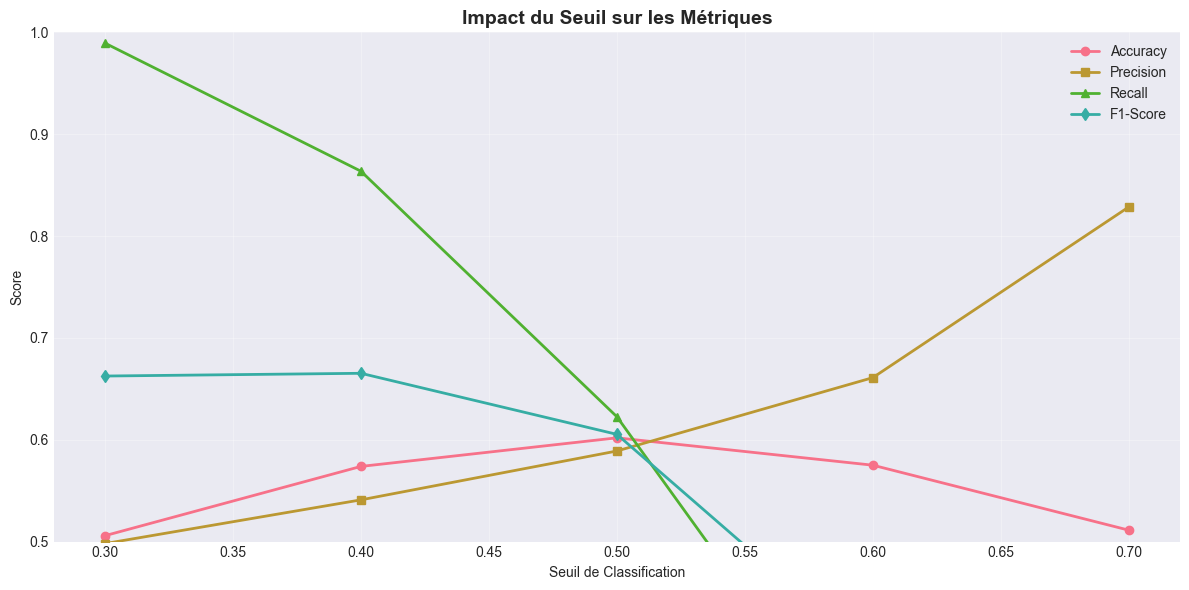


Meilleur F1-Score : 0.6652 (seuil = 0.4)
✓ Analyse sauvegardée : tensorflow_classification_models/threshold_analysis.png


In [13]:
"""Analyse de l'impact du seuil de classification."""

print("="*70)
print(" ANALYSE DE L'IMPACT DU SEUIL")
print("="*70)

# Test de différents seuils
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]

results = []
for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_proba > threshold).astype(int).flatten()
    
    acc = accuracy_score(y_cls_test, y_pred_threshold)
    prec = precision_score(y_cls_test, y_pred_threshold, zero_division=0)
    rec = recall_score(y_cls_test, y_pred_threshold, zero_division=0)
    f1_threshold = f1_score(y_cls_test, y_pred_threshold, zero_division=0)
    
    results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1_threshold
    })

# Affichage des résultats
results_df = pd.DataFrame(results)
print("\nMétriques selon différents seuils :")
print(results_df.to_string(index=False))

# Visualisation
fig, ax = plt.subplots(figsize=(12, 6))
x = results_df['Threshold']
ax.plot(x, results_df['Accuracy'], marker='o', label='Accuracy', linewidth=2)
ax.plot(x, results_df['Precision'], marker='s', label='Precision', linewidth=2)
ax.plot(x, results_df['Recall'], marker='^', label='Recall', linewidth=2)
ax.plot(x, results_df['F1-Score'], marker='d', label='F1-Score', linewidth=2)

ax.set_xlabel('Seuil de Classification')
ax.set_ylabel('Score')
ax.set_title('Impact du Seuil sur les Métriques', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig(f'{model_dir}/threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Meilleur F1-Score
best_f1_idx = results_df['F1-Score'].idxmax()
best_threshold = results_df.loc[best_f1_idx, 'Threshold']
best_f1 = results_df.loc[best_f1_idx, 'F1-Score']

print(f"\nMeilleur F1-Score : {best_f1:.4f} (seuil = {best_threshold})")
print(f"✓ Analyse sauvegardée : {model_dir}/threshold_analysis.png")

## 13. Sauvegarde du Modèle Final

In [14]:
"""Sauvegarde du modèle et des résultats."""

print("="*70)
print(" SAUVEGARDE DU MODÈLE")
print("="*70)

# Sauvegarde du modèle complet
model_classification.save(f'{model_dir}/final_classification_model.keras')
print(f"✓ Modèle sauvegardé : {model_dir}/final_classification_model.keras")

# Sauvegarde de l'historique
history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{model_dir}/full_training_history.csv', index=False)
print(f"✓ Historique sauvegardé : {model_dir}/full_training_history.csv")

# Sauvegarde des résultats de test
test_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_roc': auc_roc,
    'average_precision': avg_precision,
    'optimal_threshold': optimal_threshold
}

with open(f'{model_dir}/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)
print(f"✓ Résultats de test sauvegardés : {model_dir}/test_results.pkl")

# Sauvegarde des hyperparamètres
hyperparams_final = {
    **HYPERPARAMS,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'class_weights': class_weights,
    'best_val_auc': max_val_auc,
    'best_epoch': max_auc_epoch,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'{model_dir}/hyperparameters.pkl', 'wb') as f:
    pickle.dump(hyperparams_final, f)
print(f"✓ Hyperparamètres sauvegardés : {model_dir}/hyperparameters.pkl")

# Sauvegarde des prédictions
predictions_df = pd.DataFrame({
    'y_true': y_cls_test,
    'y_pred_proba': y_pred_proba.flatten(),
    'y_pred_class': y_pred_classes
})
predictions_df.to_csv(f'{model_dir}/test_predictions.csv', index=False)
print(f"✓ Prédictions sauvegardées : {model_dir}/test_predictions.csv")

print("\n" + "="*70)
print(" RÉSUMÉ")
print("="*70)
print(f"\nDossier : {model_dir}/")
print(f"\nFichiers créés :")
for file in sorted(os.listdir(model_dir)):
    file_path = os.path.join(model_dir, file)
    if os.path.isfile(file_path):
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"  - {file:40s} ({file_size:>10.2f} KB)")

print("\n✓ Classification binaire terminée avec succès !")
print("\nProchaine étape : 05_tensorflow_comparison.ipynb")

 SAUVEGARDE DU MODÈLE
✓ Modèle sauvegardé : tensorflow_classification_models/final_classification_model.keras
✓ Historique sauvegardé : tensorflow_classification_models/full_training_history.csv
✓ Résultats de test sauvegardés : tensorflow_classification_models/test_results.pkl
✓ Hyperparamètres sauvegardés : tensorflow_classification_models/hyperparameters.pkl
✓ Prédictions sauvegardées : tensorflow_classification_models/test_predictions.csv

 RÉSUMÉ

Dossier : tensorflow_classification_models/

Fichiers créés :
  - best_classification_model.keras          (    809.32 KB)
  - confusion_matrix.png                     (    192.66 KB)
  - final_classification_model.keras         (    809.32 KB)
  - full_training_history.csv                (     14.98 KB)
  - hyperparameters.pkl                      (      0.35 KB)
  - roc_pr_curves.png                        (    259.54 KB)
  - test_predictions.csv                     (    226.93 KB)
  - test_results.pkl                         (      0.